In [2]:
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
print("all installed ")

all installed 


In [3]:
df = pd.read_excel("Online Retail dataset ML.xlsx")

# Show first few rows
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
# clean data set 

In [5]:
# Remove rows without customer ID
df = df.dropna(subset=['CustomerID'])

# Remove returns/negative quantities
df = df[df['Quantity'] > 0]

# Create Monetary column
df['Monetary'] = df['Quantity'] * df['UnitPrice']

df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Monetary
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [6]:
# Get max date from InvoiceDate
max_date = df['InvoiceDate'].max()

# Compute Recency, Frequency, Monetary
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (max_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'Monetary': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']

rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12431.0,0,1,358.25
12433.0,0,1,1919.14
12583.0,0,1,855.86
12662.0,0,1,261.48
12748.0,0,1,4.95


In [7]:
# Standardization
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)


In [8]:
# K-Means Clustering

kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster_KMeans'] = kmeans.fit_predict(rfm_scaled)

rfm[['Recency', 'Frequency', 'Monetary', 'Cluster_KMeans']].head()


,Recency,Frequency,Monetary,Cluster_KMeans
CustomerID,,,,
12431.0,0,1,358.25,0
12433.0,0,1,1919.14,2
12583.0,0,1,855.86,0
12662.0,0,1,261.48,0
12748.0,0,1,4.95,0


In [9]:
# Agglomerative Clustering

agg = AgglomerativeClustering(n_clusters=3)
rfm['Cluster_Agg'] = agg.fit_predict(rfm_scaled)

rfm[['Recency', 'Frequency', 'Monetary', 'Cluster_Agg']].head()


,Recency,Frequency,Monetary,Cluster_Agg
CustomerID,,,,
12431.0,0,1,358.25,0
12433.0,0,1,1919.14,1
12583.0,0,1,855.86,0
12662.0,0,1,261.48,0
12748.0,0,1,4.95,0


In [10]:
# DBSCAN Clustering

dbscan = DBSCAN(eps=0.7, min_samples=4)
rfm['Cluster_DBSCAN'] = dbscan.fit_predict(rfm_scaled)

rfm[['Recency', 'Frequency', 'Monetary', 'Cluster_DBSCAN']].head()


,Recency,Frequency,Monetary,Cluster_DBSCAN
CustomerID,,,,
12431.0,0,1,358.25,0
12433.0,0,1,1919.14,-1
12583.0,0,1,855.86,0
12662.0,0,1,261.48,0
12748.0,0,1,4.95,0


In [11]:
# Create Labels for Classification (Value Groups)

rfm['ValueGroup'] = pd.qcut(rfm['Monetary'], q=3, labels=[0,1,2])

rfm.head()


,Recency,Frequency,Monetary,Cluster_KMeans,Cluster_Agg,Cluster_DBSCAN,ValueGroup
CustomerID,,,,,,,
12431.0,0,1,358.25,0,0,0,1
12433.0,0,1,1919.14,2,1,-1,2
12583.0,0,1,855.86,0,0,0,2
12662.0,0,1,261.48,0,0,0,1
12748.0,0,1,4.95,0,0,0,0


In [12]:
# Split Data for Classification

X = rfm[['Recency', 'Frequency', 'Monetary']]
y = rfm['ValueGroup']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [13]:
# Logistic Regression Model

log_model = LogisticRegression(max_iter=300)
log_model.fit(X_train, y_train)

y_pred_log = log_model.predict(X_test)


In [14]:
# Random forest model

rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)


In [15]:
# SVM Model

svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)


In [16]:
# Evaluation Reports

print("\nLogistic Regression Results:")
print(classification_report(y_test, y_pred_log))

print("\nRandom Forest Results:")
print(classification_report(y_test, y_pred_rf))

print("\nSVM Results:")
print(classification_report(y_test, y_pred_svm))

print("\nAccuracy Scores:")
print("Logistic Regression:", accuracy_score(y_test, y_pred_log))
print("Random Forest:", accuracy_score(y_test, y_pred_rf))
print("SVM:", accuracy_score(y_test, y_pred_svm))



Logistic Regression Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14


Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14


SVM Results:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.75      1.00      0.86         3
       

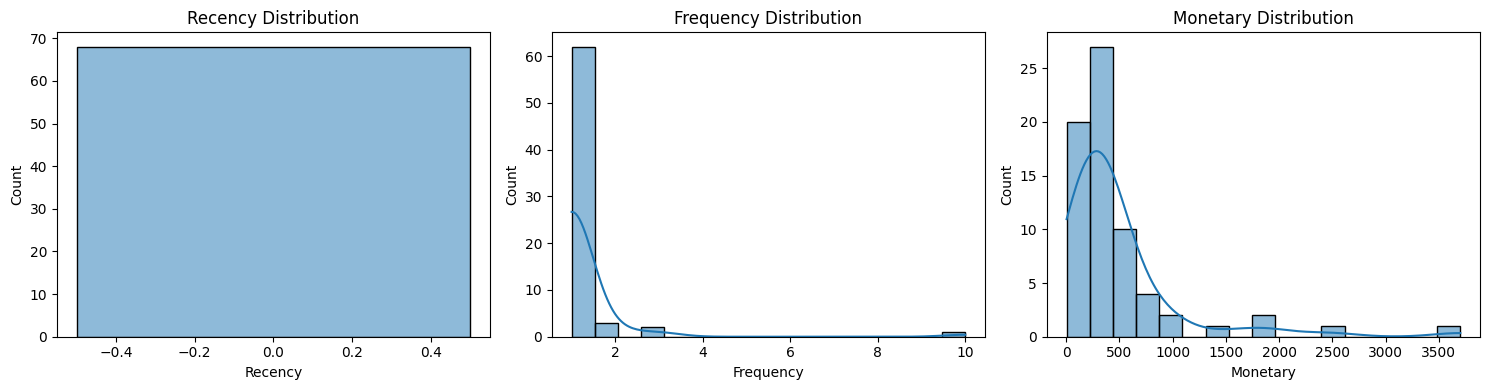

In [19]:
# PLOTS 
# RFM Distribution Plots


import matplotlib.pyplot as plt
import seaborn as sns

# RFM Distribution
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sns.histplot(rfm['Recency'], kde=True)
plt.title("Recency Distribution")

plt.subplot(1, 3, 2)
sns.histplot(rfm['Frequency'], kde=True)
plt.title("Frequency Distribution")

plt.subplot(1, 3, 3)
sns.histplot(rfm['Monetary'], kde=True)
plt.title("Monetary Distribution")

plt.tight_layout()
plt.show()


In [18]:
!pip install matplotlib seaborn scikit-learn pandas numpy openpyxl


   ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
   ---------- ----------------------------- 2.1/8.3 MB 14.7 MB/s eta 0:00:01
   -------------------- ------------------- 4.2/8.3 MB 13.9 MB/s eta 0:00:01
   ---------------------------------- ----- 7.1/8.3 MB 12.7 MB/s eta 0:00:01
   ---------------------------------------- 8.3/8.3 MB 12.8 MB/s  0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 12.7 MB/s  0:00:00
   ---------------------------------------- 0.0/7.1 MB ? eta -:--:--
   -------------- ------------------------- 2.6/7.1 MB 15.5 MB/s eta 0:00:01
   ------------------------------ --------- 5.5/7.1 MB 14.1 MB/s eta 0:00:01
   ---------------------------------------- 7.1/7.1 MB 13.6 MB/s  0:00:00

   ---------------------------------------- 0/8 [pyparsing]
   ---------------------------------------- 0/8 [pyparsing]
   ---------------------------------------- 0/8 [pyparsing]
   --


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


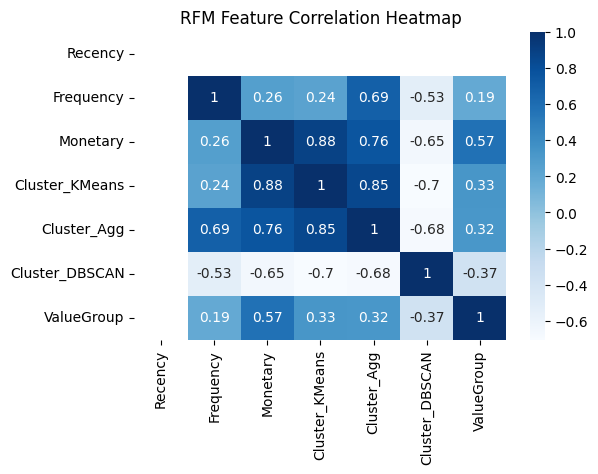

In [21]:
# Heatmap of Correlations

plt.figure(figsize=(6, 4))
sns.heatmap(rfm.corr(), annot=True, cmap="Blues")
plt.title("RFM Feature Correlation Heatmap")
plt.show()


In [22]:
# Cluster Visualization Using PCA

from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(rfm_scaled)

rfm['PCA1'] = pca_result[:, 0]
rfm['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(7, 5))
sns.scatterplot(
    x='PCA1', 
    y='PCA2', 
    hue='Cluster', 
    palette='Set2', 
    data=rfm,
    alpha=0.7
)
plt.title("K-Means Cluster Visualization (PCA Reduced)")
plt.show()



ValueError: Could not interpret value `Cluster` for `hue`. An entry with this name does not appear in `data`.

<Figure size 700x500 with 0 Axes>

In [23]:
# Cluster Centers Heatmap

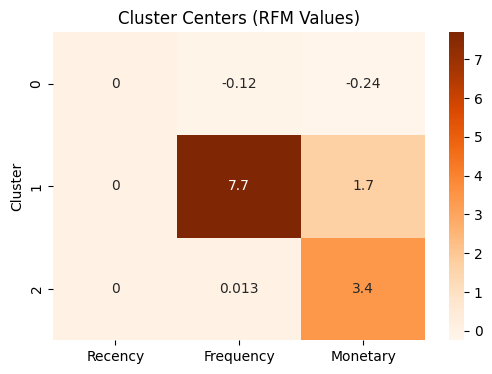

In [24]:
cluster_centers = pd.DataFrame(
    kmeans.cluster_centers_, 
    columns=['Recency', 'Frequency', 'Monetary']
)

plt.figure(figsize=(6, 4))
sns.heatmap(cluster_centers, annot=True, cmap="Oranges")
plt.title("Cluster Centers (RFM Values)")
plt.ylabel("Cluster")
plt.show()


KeyError: 'Cluster'

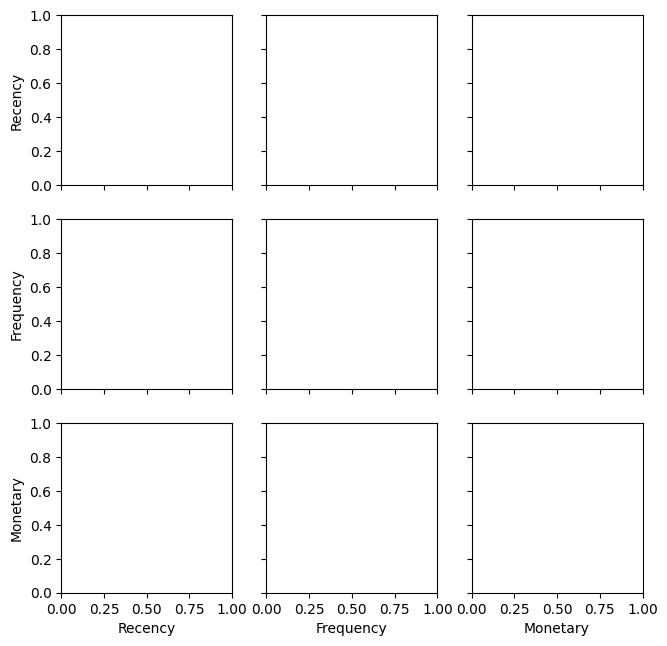

In [25]:
# Pairplot of RFM Colored by Cluster

sns.pairplot(rfm, vars=['Recency', 'Frequency', 'Monetary'], hue='Cluster', palette='Set2')
plt.show()
